In [10]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from matplotlib.pyplot import MultipleLocator
import os
from os.path import dirname

In [11]:
#read in Bitcoin dataframe
parent_dir = os.path.dirname(os.getcwd())
traincsv = pd.read_csv(parent_dir +  "/data/BTC ML Final.csv", header=0)
df = pd.DataFrame(traincsv)
window=5
time1=df.iloc[window:,0]
df.head()

,Date,HL,OC,AdjClose,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility
0,18/10/2014,0.042713,-0.019444,391.441986,11416800.0,1.962996,0,75.469711,0.760150,0.835494,-0.239850,-3.865832,-0.037463,-17386392.0,0.060301
1,19/10/2014,0.019360,0.004365,389.545990,5914570.0,-0.486719,0,79.658723,0.706411,0.793553,-0.293589,-2.739588,-0.097958,-23300962.0,0.060942
2,20/10/2014,0.031281,0.016407,382.845001,16419000.0,-1.750314,1,73.241668,0.192464,0.678191,-0.807536,-2.360535,-0.055866,-39719962.0,0.055016
3,21/10/2014,0.031016,-0.010601,386.475006,14188900.0,0.939260,0,72.644511,0.213990,0.565904,-0.786010,-1.747082,-0.050244,-25531062.0,0.046441
4,22/10/2014,0.016552,0.007666,383.157990,11641300.0,-0.865705,0,65.480216,0.032870,0.441208,-0.967130,-1.511153,-0.095417,-37172362.0,0.045207


In [3]:
#drop out unwanted data
df.drop(df.columns[[0]], axis=1, inplace=True) 
order = ['HL', 'OC','Volume','ChangePer','UpDownSign','RSI','STCK','STCD ','WILLS','MACD','ROCP', 'OBV','volatility','AdjClose']
df=df[order]
df.head()

,HL,OC,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility,AdjClose
0,0.042713,-0.019444,11416800.0,1.962996,0,75.469711,0.760150,0.835494,-0.239850,-3.865832,-0.037463,-17386392.0,0.060301,391.441986
1,0.019360,0.004365,5914570.0,-0.486719,0,79.658723,0.706411,0.793553,-0.293589,-2.739588,-0.097958,-23300962.0,0.060942,389.545990
2,0.031281,0.016407,16419000.0,-1.750314,1,73.241668,0.192464,0.678191,-0.807536,-2.360535,-0.055866,-39719962.0,0.055016,382.845001
3,0.031016,-0.010601,14188900.0,0.939260,0,72.644511,0.213990,0.565904,-0.786010,-1.747082,-0.050244,-25531062.0,0.046441,386.475006
4,0.016552,0.007666,11641300.0,-0.865705,0,65.480216,0.032870,0.441208,-0.967130,-1.511153,-0.095417,-37172362.0,0.045207,383.157990


In [4]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(df)
df = pd.DataFrame(df)
df.columns=['HL', 'OC','Volume','ChangePer','UpDownSign','RSI','STCK','STCD ','WILLS','MACD','ROCP', 'OBV','volatility','AdjClose']
df.tail()

,HL,OC,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility,AdjClose
2335,0.055118,0.456523,0.125060,0.705901,0.0,0.768888,0.842607,0.970077,0.842607,0.715501,0.045337,0.845581,0.164980,0.968218
2336,0.131080,0.496987,0.189215,0.673674,0.0,0.611894,0.468346,0.893798,0.468346,0.687995,0.127313,0.822418,0.227425,0.912620
2337,0.087582,0.378946,0.170213,0.766099,1.0,0.660953,0.506680,0.823020,0.506680,0.671676,0.069318,0.845581,0.211167,0.927320
2338,0.115625,0.349064,0.171662,0.791709,1.0,0.659622,0.630440,0.769999,0.630440,0.678083,0.100882,0.868744,0.217896,0.961153
2339,0.133230,0.424267,0.161865,0.731053,0.0,0.699880,0.425895,0.687630,0.425895,0.669709,0.114203,0.845581,0.212604,0.944581


In [76]:
#set the amount of feature
feanum=14
#set the window of prediction
#the prediction is based on all the information observed within a window of 5 days
stock=df
seq_len=window
amount_of_features = len(stock.columns)
#turn the datafram into array
data = stock.values
#transform data according to window and features
#LSTM expect our data to be in a specific format, usually a 3D array.
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
result = np.array(result)
#split data into training data and testing data
#you may change the cut to test different period
cut=30
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

In [77]:
#the shape of training data and testing data
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2304, 5, 14)
y_train (2304,)
X_test (30, 5, 14)
y_test (30,)


In [78]:
#LSTM model construction
d = 0.01
#initialize the neural network 
model = Sequential()
#add the Long Short-Term Memory layer
model.add(LSTM(128, input_shape=(window, feanum), return_sequences=True))
#add dropout layers that prevent overfitting 
model.add(Dropout(d))
#add the Long Short-Term Memory layer
model.add(LSTM(128, input_shape=(window, feanum), return_sequences=False))
#add dropout layers that prevent overfitting 
model.add(Dropout(d))
#add a densely connected neural network layer 
model.add(Dense(4,activation='relu')) 
model.add(Dense(1,activation='relu')) 
#compile model using the popular adam optimizer and set the loss as the mean_squarred_error
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs =100, batch_size = 32)

Epoch 1/100
72/72 [==============================] - 3s 6ms/step - loss: 0.0089 - accuracy: 2.6591e-04
Epoch 2/100
72/72 [==============================] - 0s 6ms/step - loss: 5.2955e-04 - accuracy: 1.1891e-05
Epoch 3/100
72/72 [==============================] - 0s 6ms/step - loss: 1.8554e-04 - accuracy: 5.5997e-05
Epoch 4/100
72/72 [==============================] - 0s 6ms/step - loss: 1.8440e-04 - accuracy: 5.6805e-04
Epoch 5/100
72/72 [==============================] - 0s 6ms/step - loss: 1.0773e-04 - accuracy: 1.6930e-04
Epoch 6/100
72/72 [==============================] - 0s 6ms/step - loss: 1.5437e-04 - accuracy: 4.3676e-04
Epoch 7/100
72/72 [==============================] - 0s 6ms/step - loss: 1.0047e-04 - accuracy: 2.2461e-04
Epoch 8/100
72/72 [==============================] - 0s 6ms/step - loss: 1.1843e-04 - accuracy: 3.0240e-05
Epoch 9/100
72/72 [==============================] - 0s 6ms/step - loss: 1.1944e-04 - accuracy: 0.0012
Epoch 10/100
72/72 [=========================

In [79]:
#LSTM model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 128)            73216     
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 516       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 205,321
Trainable params: 205,321
Non-trainable params: 0
________________________________________________

In [80]:
#model prediction outcome
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

In [81]:
X_test_reverse = X_test[:,window-1,:].reshape((X_test.shape[0], X_test.shape[2]))
y_test_predict=y_test_predict.reshape(X_test_reverse.shape[0],1)
#invert scaling for forecast testing data
inv_y_test = np.concatenate((X_test_reverse[:, :13],y_test_predict), axis=1)
inv_y_test2 = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test2[:,-1]

In [82]:
#invert scaling for actual testing data
y_test_reverse = y_test.reshape((len(y_test), 1))
inv_y1 = np.concatenate((X_test_reverse[:, :13],y_test_reverse), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y2 = inv_y1[:, -1]

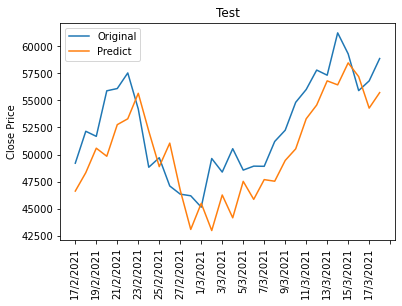

In [99]:
#plot the original and predict testing data
plt.plot(time1[-cut:],inv_y2,label='Original')
plt.plot(time1[-cut:],inv_y_predict,label='Predict')
x_major_locator=MultipleLocator(2)
ax=plt.gca()
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(x_major_locator)
plt.ylabel('Close Price')
plt.title('Test')
plt.legend()
plt.show()

In [84]:
X_train2 = X_train[:,window-1,:].reshape((X_train.shape[0], X_train.shape[2]))
y_train_predict1=y_train_predict.reshape(X_train.shape[0],1)
# invert scaling for forecast training data
inv_y_train = np.concatenate((X_train2[:, :13],y_train_predict1), axis=1)
inv_y_train2 = scaler.inverse_transform(inv_y_train)
inv_y_train=inv_y_train2[:,-1]

In [85]:
# invert scaling for actual training data
y_train2 = y_train.reshape((len(y_train), 1))
inv_y3 = np.concatenate((X_train2[:, :13],y_train2), axis=1)
inv_y3 = scaler.inverse_transform(inv_y3)
inv_y4 = inv_y3[:, -1]

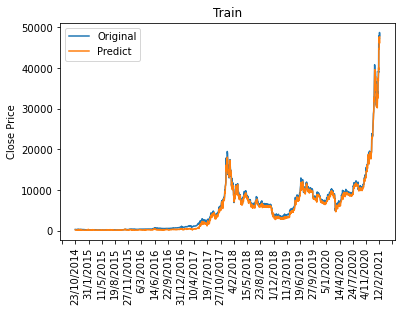

In [98]:
#plot the original and predict training data
plt.plot(time1[:-cut-1],inv_y4,label='Original')
plt.plot(time1[:-cut-1],inv_y_train,label='Predict')
x_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=90)
plt.ylabel('Close Price')
plt.title('Train')
plt.legend()
plt.show()

In [87]:
#score the result by MSE,MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('MAE/MSE of training data')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print('MAE/MSE of testing data')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )

MAE/MSE of training data
0.006974522911141531
8.305422076993043e-05
MAE/MSE of testing data
0.04631841136965399
0.0029394759990470595


In [88]:
#the accuracy rate of price movements
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('the accuracy rate of price movements of testing data:',result)
y_var_train=y_train[1:]-y_train[:len(y_train)-1]
y_var_predict1=y_train_predict[1:]-y_train_predict[:len(y_train_predict)-1]
txt1=np.zeros(len(y_var_train))
for i in range(len(y_var_train-1)):
    txt1[i]=np.sign(y_var_train[i])==np.sign(y_var_predict1[i])
result1=sum(txt1)/len(txt1)
print('the accuracy rate of price movements of training data:',result1)

the accuracy rate of price movements of testing data: 0.41379310344827586
the accuracy rate of price movements of training data: 0.654363873208858
